In [1]:
lines = r"""1 45571U 20025AS  23365.96197248  .00503980  13035-3  71339-3 0  8283\
2 45571  53.0305 356.1487 0008442  93.8422 357.0633 16.05036521205441
1 58664U 23208E   23365.96274149  .03637511  24924-5  62501-3 0    85\
2 58664  97.3803 118.4678 0190328  22.9094 113.3380 15.98433958   740
1 25544U 98067A   24001.01267188  .00016541  00000-0  29758-3 0  5694\
2 25544  51.6422  68.6294 0003347 343.4617  78.0593 15.49961425432470"""

lines = lines.split("\n")
print(lines)

['1 45571U 20025AS  23365.96197248  .00503980  13035-3  71339-3 0  8283\\', '2 45571  53.0305 356.1487 0008442  93.8422 357.0633 16.05036521205441', '1 58664U 23208E   23365.96274149  .03637511  24924-5  62501-3 0    85\\', '2 58664  97.3803 118.4678 0190328  22.9094 113.3380 15.98433958   740', '1 25544U 98067A   24001.01267188  .00016541  00000-0  29758-3 0  5694\\', '2 25544  51.6422  68.6294 0003347 343.4617  78.0593 15.49961425432470']


In [2]:
import torch
from matplotlib import pyplot as plt
from customTLE import CustomTLE
import customMLDSGP4

device = torch.device("cuda")
print(f"Current Device: {device}")

ml_dsgp4 = customMLDSGP4.mldsgp4(hidden_size=35)



Current Device: cuda


In [3]:
tle_list = []
i = 0
record = []
while i < len(lines) -1:
    record.append([lines[i], lines[i+1]])
    i+=2

for instance in record:
    tle = CustomTLE(instance)
    tle_list.append(tle)
    
print(len(tle_list))

3


In [ ]:

print("Finished reading into TLE objects")
print("Starting simulation")

tles_expanded = []
for tle in tle_list:
    tles_expanded += [tle]*10000

tsinces = torch.cat([torch.linspace(0,48*60,10000)]*len(tle_list))

with torch.no_grad():    
    states_normalized_out = ml_dsgp4(tles_expanded, tsinces)

states_normalized_out=states_normalized_out.detach().clone().numpy()

print(f"Propagating {len(tle_list)} TLEs")

_, batched_tle = customMLDSGP4.initialize_tle(tles_expanded)
states_teme = customMLDSGP4.propagate_batch(batched_tle, tsinces)

print("Finished propagation")

Finished reading into TLE objects
Starting simulation
Propagating 3 TLEs
Finished propagation


In [5]:
print(tles_expanded[0]["_epoch"])

2023-12-31 23:05:14.422271


(np.float64(-10870.94410462876),
 np.float64(11464.51203070161),
 np.float64(-11153.865193278172),
 np.float64(11181.590942052197),
 np.float64(-8386.28700356969),
 np.float64(8365.305097928089))

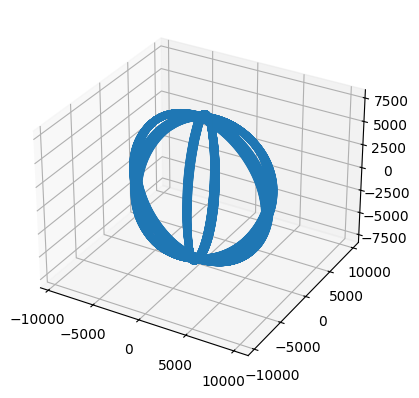

In [ ]:

#unnormalize so we can see the true paths
position=states_normalized_out[:,:3]*ml_dsgp4.normalization_R
velocity=states_normalized_out[:,3:]*ml_dsgp4.normalization_V

#plots in R^3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(position[:,0], position[:,1], position[:,2])
ax.axis('equal')